# Hiragana Classification

## Data Wrangling

In [1]:
from datasets import download_data

In [3]:
download_data.run()

All dataset files downloaded!


In [4]:
import numpy as np
import os
def load_dataset():
    path_names = ['train-labels', 'train-imgs', 'test-labels', 'test-imgs']
    return [np.load(os.path.join("datasets", "k49-") + i + '.npz')['arr_0'] for i in path_names]

In [55]:
train_y, train_X, test_y, test_X = load_dataset()
train_X.shape

(232365, 28, 28)

The image is 28x28 pixels and absence of third dimension indicates that the image is grey scale.

In [6]:
test_y

array([19, 23, 10, ...,  1, 27, 47], dtype=uint8)

The labels seem to be not one-hot encoded. We would need to one-hot encode it or configure models to support sparse labels.

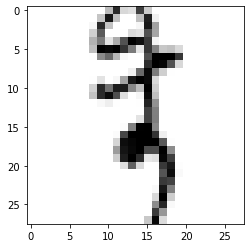

In [7]:
import matplotlib.pyplot as plt

plt.imshow(train_X[0], cmap='binary')
plt.show()

It doesn't seem that we need data cleaning for this particular task. We would, however, need to scale the grey scale to range 0-1 in order for Gradient Descent algorithm to work well.

In [73]:
# Scailing grey scale
train_X = train_X/255.0
test_X = test_X/255.0

## Data Exploration

In [56]:
import pandas as pd
import seaborn as sns
label_df = pd.read_csv(os.path.join('datasets', 'k49_classmap.csv'))
label_df.tail(5)

,index,codepoint,char
44,44,U+3090,ゐ
45,45,U+3091,ゑ
46,46,U+3092,を
47,47,U+3093,ん
48,48,U+309D,ゝ


I found very uncommon character at index 44, 45, and 48. I will remove these as these are barely used in the conversation.

In [59]:
def remove_uncommon_characters(y, X):
    """
    Remove unwanted labels which correspond to very uncommon characters used in Japan.
    It also re-label those following characters.
    """
    labels = [44, 45, 48]
    indices = []
    for i in range(len(X)):
        if y[i] in labels:
            indices.append(i)
            continue
            
        if y[i] == 46:
            y[i] = 44
            continue
        
        if y[i] == 47:
            y[i] = 45
            continue
    
    return np.delete(y, indices), np.delete(X, indices, axis=0)

In [60]:
# remove the characters from labels as well.
label_df = label_df.drop([44, 45, 48])
label_df.reset_index(drop=True)    
label_df['index'] = label_df.index

In [61]:
train_y, train_X = remove_uncommon_characters(train_y, train_X)
test_y, test_X = remove_uncommon_characters(test_y, test_X)

In [64]:
label_df.tail(5)

,index,codepoint,char
41,41,U+308C,れ
42,42,U+308D,ろ
43,43,U+308F,わ
46,46,U+3092,を
47,47,U+3093,ん


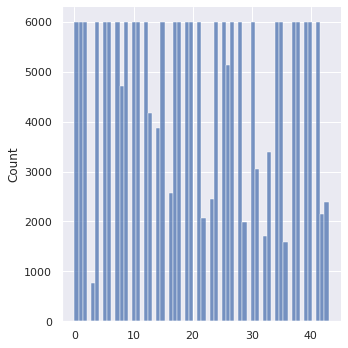

In [65]:
sns.set_theme()
sns.displot(train_y)

We have 6k instances for each character, but for some character, we have less. Especially, it seems that data on some character is a lot less than 6000 observations.

In [66]:
train_y_df = pd.DataFrame({'label': train_y})
counts = train_y_df['label'].value_counts()

In [67]:
counts_df = counts[counts < 3000].to_frame()
counts_df.join(label_df)

,label,index,codepoint,char
16,2565,16,U+3061,ち
23,2451,23,U+306D,ね
43,2397,43,U+308F,わ
42,2139,42,U+308D,ろ
22,2063,22,U+306C,ぬ
29,1993,29,U+307B,ほ
32,1718,32,U+3080,む
36,1598,36,U+3086,ゆ
3,777,3,U+3048,え


It makes sense that these characters don't have many observations as they are relatively uncommon. For neural network, we might need to tweak weights on these uncommon characters.

In [ ]:
counts.to_frame().sort_value('index')

## Building Models
The performance measure I will use for models is accuracy.

In [152]:
def calculate_accuracy(actual, predicted):
    return (test_y == y_hats).mean()

In [19]:
def show_score(scores):
    print(f'CV Accuracy Mean: {scores.mean()}')
    print(f'std: {scores.std()}' )

### RandomForest

In [15]:
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier()
rf_clf.fit(train_X.reshape(-1, 28 * 28), train_y)

RandomForestClassifier()

In [143]:
import pickle

with open("models/rf.pkl", 'wb') as f:
    pickle.dump(rf_clf, f)

In [20]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(rf_clf, train_X.reshape(-1, 28 * 28), train_y, scoring="accuracy", cv=10)
show_score(scores)

mean: 0.885213965505805
std: {scores.std()}


In [153]:
y_hats = rf_clf.predict(test_X.reshape(-1, 28 * 28))
print(f'test accuracy: {calculate_accuracy(test_y, y_hats)}')

test accuracy: 0.7496366375095795


### XGBoost

In [18]:
from xgboost import XGBClassifier

xgb_clf = XGBClassifier(tree_method='gpu_hist')
xgb_clf.fit(train_X.reshape(-1, 28 * 28), train_y)

[00:08:11] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=0,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=12, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='gpu_hist', validate_parameters=1, verbosity=None)

In [24]:
import pickle

with open("models/xgb.pkl", 'wb') as f:
    pickle.dump(xgb_clf, f)

In [21]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(rf_clf, train_X.reshape(-1, 28 * 28), train_y, scoring="accuracy", cv=10)
show_score(scores)

mean: 0.8850429442243506
std: {scores.std()}


In [154]:
y_hats = xgb_clf.predict(test_X.reshape(-1, 28 * 28))
print(f'test accuracy: {calculate_accuracy(test_y, y_hats)}')

test accuracy: 0.7634047726011469


The reasons why CV accuracy is not a good estimator of test accuracy might come from the fact that the ratio of characters in train set is different from test set. Anyways, these models don't perform well. I'd think no hyper-parameter tuning needed.

### Sequential #1
- A sequential nnet with a simple architecture. 
- Output activiation is softmax as this is a multi-label classification whose labels are exclusive. 
- ReLU is a nice default hidden activation function. 
- We will use cross entropy as loss function and stochastic gradient descent as optimizer as a starting point.

In [98]:
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.models import Sequential

def build_seq_one():
    model = Sequential()
    model.add(Flatten(input_shape=[28, 28]))
    model.add(Dense(512, activation='relu'))
    model.add(Dense(256, activation='relu'))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(48, activation='softmax'))
    
    return model

In [99]:
model1 = build_seq_one()
model1.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_6 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_24 (Dense)             (None, 512)               401920    
_________________________________________________________________
dense_25 (Dense)             (None, 256)               131328    
_________________________________________________________________
dense_26 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_27 (Dense)             (None, 48)                6192      
Total params: 572,336
Trainable params: 572,336
Non-trainable params: 0
_________________________________________________________________


In [100]:
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.losses import sparse_categorical_crossentropy
model1.compile(loss=sparse_categorical_crossentropy,
             optimizer= SGD(learning_rate=0.001),
             metrics=["accuracy"])

In [101]:
history = model1.fit(train_X, train_y, epochs=30, validation_split=0.2)

Epoch 1/30

   1/5401 [..............................] - ETA: 14:03 - loss: 3.9199 - accuracy: 0.0000e+00

2021-10-11 17:35:04.502384: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 541982336 exceeds 10% of free system memory.


5401/5401 [==============================] - 11s 2ms/step - loss: 3.3802 - accuracy: 0.2012 - val_loss: 2.6802 - val_accuracy: 0.4182
Epoch 2/30
5401/5401 [==============================] - 10s 2ms/step - loss: 2.1250 - accuracy: 0.5100 - val_loss: 1.7914 - val_accuracy: 0.5683
Epoch 3/30
5401/5401 [==============================] - 10s 2ms/step - loss: 1.6246 - accuracy: 0.5994 - val_loss: 1.5155 - val_accuracy: 0.6207
Epoch 4/30
5401/5401 [==============================] - 10s 2ms/step - loss: 1.4273 - accuracy: 0.6408 - val_loss: 1.3731 - val_accuracy: 0.6536
Epoch 5/30
5401/5401 [==============================] - 10s 2ms/step - loss: 1.3086 - accuracy: 0.6681 - val_loss: 1.2754 - val_accuracy: 0.6794
Epoch 6/30
5401/5401 [==============================] - 10s 2ms/step - loss: 1.2229 - accuracy: 0.6893 - val_loss: 1.2043 - val_accuracy: 0.6961
Epoch 7/30
5401/5401 [==============================] - 11s 2ms/step - loss: 1.1546 - accuracy: 0.7065 - val_loss: 1.1413 - val_accuracy: 0.7

<AxesSubplot:>

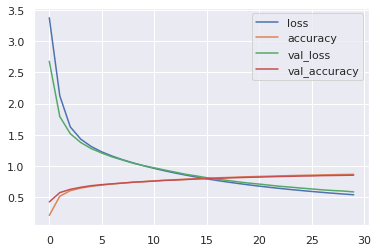

In [104]:
pd.DataFrame(history.history).plot()

In [114]:
model1.evaluate(test_X, test_y)

1183/1183 [==============================] - 1s 1ms/step - loss: 1.6024 - accuracy: 0.7510


[1.602389931678772, 0.7509579658508301]

The simple sequential model seems to suffer from overfitting. It doesn't generalise well and performs even worse than random forest or xgboost. It might not be good idea to proceed with this model.

### CNN #1

In [136]:
from keras.layers import Conv2D, MaxPooling2D, Dropout

def build_cnn_one():
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3,3),
                    activation="relu",
                    input_shape=[28, 28, 1]))
    model.add(Conv2D(64, (3,3), activation="relu"))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(48, activation='softmax'))
    
    return model

In [137]:
model = build_cnn_one()
model.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 12, 12, 64)        0         
_________________________________________________________________
flatten_9 (Flatten)          (None, 9216)              0         
_________________________________________________________________
dense_32 (Dense)             (None, 256)               2359552   
_________________________________________________________________
dropout_5 (Dropout)          (None, 256)             

In [138]:
model.compile(loss=sparse_categorical_crossentropy,
             optimizer=SGD(learning_rate=0.001, momentum=0.9, nesterov=True),
             metrics=['accuracy'])

In [139]:
model.fit(train_X.reshape(train_X.shape[0], 28,28,1), train_y, epochs=20, validation_split=0.2)

Epoch 1/20
5401/5401 [==============================] - 126s 23ms/step - loss: 1.5280 - accuracy: 0.6011 - val_loss: 0.7611 - val_accuracy: 0.8001
Epoch 2/20
5401/5401 [==============================] - 126s 23ms/step - loss: 0.8691 - accuracy: 0.7650 - val_loss: 0.4764 - val_accuracy: 0.8734
Epoch 3/20
5401/5401 [==============================] - 126s 23ms/step - loss: 0.6458 - accuracy: 0.8245 - val_loss: 0.3694 - val_accuracy: 0.9003
Epoch 4/20
5401/5401 [==============================] - 126s 23ms/step - loss: 0.5369 - accuracy: 0.8520 - val_loss: 0.3096 - val_accuracy: 0.9172
Epoch 5/20
5401/5401 [==============================] - 128s 24ms/step - loss: 0.4689 - accuracy: 0.8703 - val_loss: 0.2727 - val_accuracy: 0.9256
Epoch 6/20
5401/5401 [==============================] - 127s 23ms/step - loss: 0.4217 - accuracy: 0.8821 - val_loss: 0.2510 - val_accuracy: 0.9318
Epoch 7/20
5401/5401 [==============================] - 128s 24ms/step - loss: 0.3890 - accuracy: 0.8906 - val_loss: 0

<AxesSubplot:>

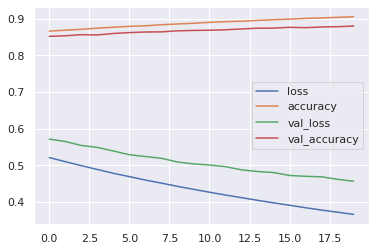

In [140]:
pd.DataFrame(history.history).plot() 

In [168]:
model.evaluate(test_X.reshape(test_X.shape[0], 28,28,1), test_y)

1183/1183 [==============================] - 6s 5ms/step - loss: 1.0285 - accuracy: 0.8642


[1.0285084247589111, 0.8641684651374817]

Pretty good performnce for its simplicity.

### CNN #2 - Deeper 

In [176]:
def build_cnn_two():
    model = Sequential([
        Conv2D(64, 7, activation='relu', padding='same', input_shape=[28,28,1]),
        MaxPooling2D(2),
        Conv2D(128, 3, activation='relu', padding='same'),
        Conv2D(128, 3, activation='relu', padding='same'),
        MaxPooling2D(2),
        Conv2D(256, 3, activation='relu', padding='same'),
        Conv2D(256, 3, activation='relu', padding='same'),
        MaxPooling2D(2),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(48, activation='softmax')
    ])
    
    return model
    
model = build_cnn_two()

In [177]:
from tensorflow.keras.optimizers import Adam

model.compile(loss=sparse_categorical_crossentropy,
             optimizer=Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999),
             metrics=['accuracy'])

In [178]:
model.fit(train_X.reshape(train_X.shape[0], 28,28,1), train_y, epochs=10, validation_split=0.2)

Epoch 1/10
5401/5401 [==============================] - 404s 75ms/step - loss: 1.5316 - accuracy: 0.5900 - val_loss: 0.3733 - val_accuracy: 0.9111
Epoch 2/10
5401/5401 [==============================] - 406s 75ms/step - loss: 0.6399 - accuracy: 0.8330 - val_loss: 0.2737 - val_accuracy: 0.9327
Epoch 3/10
5401/5401 [==============================] - 413s 77ms/step - loss: 0.4856 - accuracy: 0.8757 - val_loss: 0.2253 - val_accuracy: 0.9489
Epoch 4/10
5401/5401 [==============================] - 416s 77ms/step - loss: 0.4133 - accuracy: 0.8947 - val_loss: 0.1980 - val_accuracy: 0.9535
Epoch 5/10
5401/5401 [==============================] - 412s 76ms/step - loss: 0.3678 - accuracy: 0.9070 - val_loss: 0.1881 - val_accuracy: 0.9583
Epoch 6/10
5401/5401 [==============================] - 394s 73ms/step - loss: 0.3424 - accuracy: 0.9145 - val_loss: 0.1861 - val_accuracy: 0.9589
Epoch 7/10
5401/5401 [==============================] - 376s 70ms/step - loss: 0.3196 - accuracy: 0.9200 - val_loss: 0

In [179]:
model.evaluate(test_X.reshape(test_X.shape[0], 28,28,1), test_y)

1183/1183 [==============================] - 24s 20ms/step - loss: 2.4621 - accuracy: 0.8706


[2.4621071815490723, 0.8706429600715637]

In [ ]:
model.save(os.path.join('models', 'final_model'))

## Future work

- Some character is missing on train set and test set. It might be worth making sure the ratio is the same.
- Further fine-tune the model
I will leave it for now but I will come back to experiment further.